In [2]:
import zipfile
with zipfile.ZipFile('home-credit-default-risk.zip', 'r') as zip_ref:
    zip_ref.extractall('my_credit')


In [120]:
import pandas as pd
import numpy as np
import sklearn
import scipy as sp

In [129]:
train = pd.read_csv("my_credit/application_train.csv")
test = pd.read_csv("my_credit/application_test.csv")

In [130]:
train_size = train.shape[0]

In [131]:
data = pd.concat([train, test], axis = 0).reset_index()

In [132]:
nans = pd.concat([data.isnull().sum()],  axis=1, keys=['num_of_nans'])

In [133]:
uniques = data.nunique()
nan_cols = nans[nans['num_of_nans'] > 0].index

In [134]:
types = data.dtypes

In [135]:
for col in nan_cols:
    if types[col] == 'object':
        data[col].fillna(data[col].mode()[0], inplace = True)
    else:
        if uniques[col] <= 10:
            data[col].fillna(data[col].mode()[0], inplace = True)
        else:
            data[col].fillna(data[col].median(), inplace = True)



In [136]:
nan_check = pd.concat([data.isnull().sum()],  axis=1, keys=['num_of_nans'])
nan_cols_check = nan_check[nan_check['num_of_nans'] > 0].index

In [137]:
nan_cols_check

Index([], dtype='object')

In [138]:
cat_cols = []
numerical_cols = []


In [139]:
cols = data.columns

In [140]:
for col in cols:
    if types[col] == 'object':
        cat_cols.append(col)
    else:
        if uniques[col] <= 10:
            cat_cols.append(col)
        else:
            numerical_cols.append(col)

In [141]:
cat_cols = cat_cols[1:]

In [142]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
togeth = pd.concat
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

In [143]:
numerical_dat = data[numerical_cols]
categorical_dat = data[cat_cols]

In [144]:
!pip install category_encoders
import category_encoders as ce

In [145]:
Y = data['TARGET']
data = data.drop(['TARGET'], axis = 1)

In [146]:
ce_bin = ce.BinaryEncoder(cols = cat_cols)
transfor_cat = ce_bin.fit_transform(categorical_dat, Y)

/anaconda/envs/py37_default/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [147]:
X = pd.concat([transfor_cat, numerical_dat], axis = 1)

In [160]:
test_data = X[train_size:]
X = X[:train_size]


In [ ]:
Y = Y[:train_size]

In [150]:
!pip install catboost

In [52]:
from catboost import CatBoostClassifier

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
results_samples_depth = []
max_depth = [4, 6,  8, 10]
for d in max_depth:
    clf = CatBoostClassifier(max_depth=d, verbose=False)
    kf = KFold(n_splits=4)
    kf.get_n_splits(X)
    roc_aucs = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        clf.fit(X_train, y_train)
        predict = clf.predict_proba(X_test)[:,1]
        roc_auc = roc_auc_score(y_test, predict)
        print(i, roc_auc)
        roc_aucs.append(roc_auc)
    print(roc_aucs)
    results_samples_depth.append(np.mean(roc_auc))


0 0.7597395371474138
1 0.7600523102071906
2 0.7561626249048811
3 0.760294762690342
[0.7597395371474138, 0.7600523102071906, 0.7561626249048811, 0.760294762690342]
0 0.7577758477735497
1 0.7591818436543584
2 0.7553978771253851
3 0.7575822039166733
[0.7577758477735497, 0.7591818436543584, 0.7553978771253851, 0.7575822039166733]
0 0.7452520091823087
1 0.7561409403152017
2 0.7515843588577009
3 0.7530391810392905
[0.7452520091823087, 0.7561409403152017, 0.7515843588577009, 0.7530391810392905]
0 0.7309675736130363
1 0.7459997829612204
2 0.7436310953349798
3 0.739834954602133
[0.7309675736130363, 0.7459997829612204, 0.7436310953349798, 0.739834954602133]


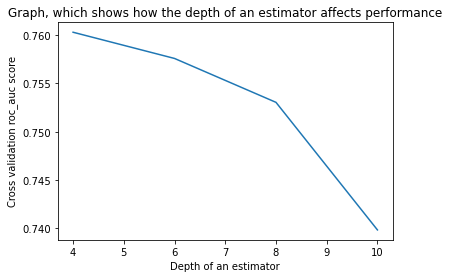

In [57]:
import matplotlib.pyplot as plt
plt.plot(max_depth, results_samples_depth)
plt.title('Graph, which shows how the depth of an estimator affects performance')
plt.xlabel('Depth of an estimator')
plt.ylabel('Cross validation roc_auc score')
plt.show()

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
results_samples_num_trees = []
num_trees = [1200, 1400, 1800]
for num_tr in num_trees:
    clf = CatBoostClassifier(max_depth=4, num_trees = num_tr, verbose=False)
    kf = KFold(n_splits=4)
    kf.get_n_splits(X)
    roc_aucs = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        clf.fit(X_train, y_train)
        predict = clf.predict_proba(X_test)[:,1]
        roc_auc = roc_auc_score(y_test, predict)
        print(i, roc_auc)
        roc_aucs.append(roc_auc)
    print(roc_aucs)
    results_samples_num_trees.append(np.mean(roc_auc))


0 0.7593801835204199
1 0.7599649299749762
2 0.7566317961102926
3 0.760230309143751
[0.7593801835204199, 0.7599649299749762, 0.7566317961102926, 0.760230309143751]
0 0.7599671163967803
1 0.7600974321655333
2 0.7566069962214679
3 0.7608561338533437
[0.7599671163967803, 0.7600974321655333, 0.7566069962214679, 0.7608561338533437]
0 0.7599275744592374
1 0.7600659205022797
2 0.7565328467343436
3 0.7604669473520173
[0.7599275744592374, 0.7600659205022797, 0.7565328467343436, 0.7604669473520173]


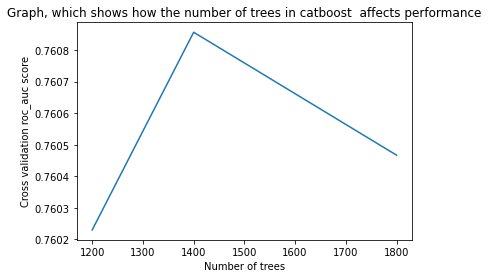

In [59]:
import matplotlib.pyplot as plt
plt.plot(num_trees, results_samples_num_trees)
plt.title('Graph, which shows how the number of trees in catboost  affects performance')
plt.xlabel('Number of trees')
plt.ylabel('Cross validation roc_auc score')
plt.show()

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
results_samples_lrs = []
lrs = [0.01, 0.03, 0.05, 0.7]
for l in lrs:
    clf = CatBoostClassifier(max_depth=4, num_trees = 1400,learning_rate=l, verbose=False)
    kf = KFold(n_splits=4)
    kf.get_n_splits(X)
    roc_aucs = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        clf.fit(X_train, y_train)
        predict = clf.predict_proba(X_test)[:,1]
        roc_auc = roc_auc_score(y_test, predict)
        print(i, roc_auc)
        roc_aucs.append(roc_auc)
    print(roc_aucs)
    results_samples_lrs.append(np.mean(roc_auc))


0 0.7535843703131598
1 0.7540614822946106
2 0.7507154492499173
3 0.7551566149626101
[0.7535843703131598, 0.7540614822946106, 0.7507154492499173, 0.7551566149626101]
0 0.7590988367685904
1 0.7587688228605196
2 0.7553710230116183
3 0.7596566049470694
[0.7590988367685904, 0.7587688228605196, 0.7553710230116183, 0.7596566049470694]
0 0.7599439242346412
1 0.7597578918228316
2 0.7562202832118843
3 0.7604933423061866
[0.7599439242346412, 0.7597578918228316, 0.7562202832118843, 0.7604933423061866]
0 0.6708855701973975
1 0.7097647616593605
2 0.7045222146260783
3 0.686634570679388
[0.6708855701973975, 0.7097647616593605, 0.7045222146260783, 0.686634570679388]


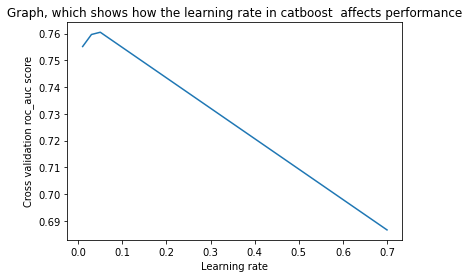

In [62]:
import matplotlib.pyplot as plt
plt.plot(lrs, results_samples_lrs)
plt.title('Graph, which shows how the learning rate in catboost  affects performance')
plt.xlabel('Learning rate')
plt.ylabel('Cross validation roc_auc score')
plt.show()

#### Larger learning rates converge to a wider minima, which means that we overfit less.
#### The number of trees also causes overfitting, but here the process is very slow.
#### As the depth of the estimator increases, the model overfits.

# Gridsearch

In [65]:
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

clf = CatBoostClassifier()
params = {'num_trees':[1350, 1450],
          'max_depth':[4, 5],
          'learning_rate':[0.06, 0.07]}
catboost_grid_search = GridSearchCV(clf, param_grid = params,scoring='roc_auc', n_jobs = -1,
                          cv = 4, verbose = 10)

In [66]:
catboost_grid_search.fit(X, Y)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done  21 out of  32 | elapsed: 16.9min remaining:  8.8min
[Parallel(n_jobs=-1)]: Done  25 out of  32 | elapsed: 20.6min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed: 22.2min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed: 22.5min finished


0:	learn: 0.6342575	total: 37.6ms	remaining: 54.6s
1:	learn: 0.5816281	total: 77.9ms	remaining: 56.4s
2:	learn: 0.5367541	total: 119ms	remaining: 57.4s
3:	learn: 0.4964953	total: 161ms	remaining: 58.1s
4:	learn: 0.4629653	total: 203ms	remaining: 58.6s
5:	learn: 0.4339529	total: 253ms	remaining: 1m
6:	learn: 0.4113251	total: 298ms	remaining: 1m 1s
7:	learn: 0.3896817	total: 343ms	remaining: 1m 1s
8:	learn: 0.3734990	total: 382ms	remaining: 1m 1s
9:	learn: 0.3582294	total: 422ms	remaining: 1m
10:	learn: 0.3458192	total: 461ms	remaining: 1m
11:	learn: 0.3358342	total: 499ms	remaining: 59.8s
12:	learn: 0.3256189	total: 543ms	remaining: 1m
13:	learn: 0.3170047	total: 581ms	remaining: 59.6s
14:	learn: 0.3097098	total: 619ms	remaining: 59.2s
15:	learn: 0.3032684	total: 659ms	remaining: 59.1s
16:	learn: 0.2973019	total: 701ms	remaining: 59.1s
17:	learn: 0.2921188	total: 744ms	remaining: 59.2s
18:	learn: 0.2878648	total: 785ms	remaining: 59.1s
19:	learn: 0.2843521	total: 825ms	remaining: 59s
20

GridSearchCV(cv=4,
             estimator=<catboost.core.CatBoostClassifier object at 0x7ff393001c50>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.06, 0.07], 'max_depth': [4, 5],
                         'num_trees': [1350, 1450]},
             scoring='roc_auc', verbose=10)

In [72]:
catboost_grid_search.best_params_

{'learning_rate': 0.06, 'max_depth': 4, 'num_trees': 1450}

In [70]:
catboost_grid_search.best_score_

0.7584843979604778

In [76]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

clf = CatBoostClassifier()
params = {'num_trees':[1200, 1350, 1450, 1500],
          'max_depth':[4, 5, 6],
          'learning_rate':[0.06, 0.07, 0.05, 0.08]}
random_grid_search = RandomizedSearchCV(clf, params, n_iter=8, scoring='roc_auc', n_jobs = -1,
                          cv = 4, verbose = 10)

In [77]:
random_grid_search.fit(X, Y)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done  21 out of  32 | elapsed: 16.6min remaining:  8.7min
[Parallel(n_jobs=-1)]: Done  25 out of  32 | elapsed: 21.1min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed: 21.8min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed: 22.0min finished


0:	learn: 0.6342575	total: 42.3ms	remaining: 57.1s
1:	learn: 0.5816281	total: 83.5ms	remaining: 56.3s
2:	learn: 0.5367541	total: 124ms	remaining: 55.9s
3:	learn: 0.4964953	total: 167ms	remaining: 56.3s
4:	learn: 0.4629653	total: 206ms	remaining: 55.5s
5:	learn: 0.4339529	total: 248ms	remaining: 55.6s
6:	learn: 0.4113251	total: 293ms	remaining: 56.2s
7:	learn: 0.3896817	total: 336ms	remaining: 56.4s
8:	learn: 0.3734990	total: 383ms	remaining: 57.1s
9:	learn: 0.3582294	total: 423ms	remaining: 56.7s
10:	learn: 0.3458192	total: 463ms	remaining: 56.3s
11:	learn: 0.3358342	total: 501ms	remaining: 55.8s
12:	learn: 0.3256189	total: 544ms	remaining: 55.9s
13:	learn: 0.3170047	total: 581ms	remaining: 55.5s
14:	learn: 0.3097098	total: 619ms	remaining: 55.1s
15:	learn: 0.3032684	total: 659ms	remaining: 55s
16:	learn: 0.2973019	total: 702ms	remaining: 55.1s
17:	learn: 0.2921188	total: 745ms	remaining: 55.1s
18:	learn: 0.2878648	total: 784ms	remaining: 54.9s
19:	learn: 0.2843521	total: 823ms	remaini

RandomizedSearchCV(cv=4,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7ff39300ac90>,
                   n_iter=8, n_jobs=-1,
                   param_distributions={'learning_rate': [0.06, 0.07, 0.05,
                                                          0.08],
                                        'max_depth': [4, 5, 6],
                                        'num_trees': [1200, 1350, 1450, 1500]},
                   scoring='roc_auc', verbose=10)

In [78]:
random_grid_search.best_params_

{'num_trees': 1350, 'max_depth': 4, 'learning_rate': 0.06}

In [79]:
random_grid_search.best_score_

0.7584471111803596

# Feature importance

In [81]:
best_catboost = CatBoostClassifier(num_trees =  1350, max_depth = 4, learning_rate = 0.06)
best_catboost.fit(X, Y)

0:	learn: 0.6342575	total: 36.5ms	remaining: 49.3s
1:	learn: 0.5816281	total: 76.2ms	remaining: 51.4s
2:	learn: 0.5367541	total: 117ms	remaining: 52.5s
3:	learn: 0.4964953	total: 161ms	remaining: 54.1s
4:	learn: 0.4629653	total: 202ms	remaining: 54.3s
5:	learn: 0.4339529	total: 243ms	remaining: 54.4s
6:	learn: 0.4113251	total: 288ms	remaining: 55.2s
7:	learn: 0.3896817	total: 331ms	remaining: 55.5s
8:	learn: 0.3734990	total: 371ms	remaining: 55.3s
9:	learn: 0.3582294	total: 410ms	remaining: 55s
10:	learn: 0.3458192	total: 449ms	remaining: 54.6s
11:	learn: 0.3358342	total: 486ms	remaining: 54.2s
12:	learn: 0.3256189	total: 530ms	remaining: 54.5s
13:	learn: 0.3170047	total: 568ms	remaining: 54.2s
14:	learn: 0.3097098	total: 606ms	remaining: 53.9s
15:	learn: 0.3032684	total: 646ms	remaining: 53.9s
16:	learn: 0.2973019	total: 689ms	remaining: 54.1s
17:	learn: 0.2921188	total: 732ms	remaining: 54.2s
18:	learn: 0.2878648	total: 772ms	remaining: 54.1s
19:	learn: 0.2843521	total: 812ms	remaini

In [83]:
X.columns

Index(['NAME_CONTRACT_TYPE_0', 'NAME_CONTRACT_TYPE_1', 'CODE_GENDER_0',
       'CODE_GENDER_1', 'CODE_GENDER_2', 'FLAG_OWN_CAR_0', 'FLAG_OWN_CAR_1',
       'FLAG_OWN_REALTY_0', 'FLAG_OWN_REALTY_1', 'NAME_TYPE_SUITE_0',
       ...
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',
       'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=218)

In [84]:
importance = best_catboost.get_feature_importance()
data={'feature_names':X.columns,'feature_importance':importance}
importance_df = pd.DataFrame(data)

In [88]:
importance_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

In [90]:
pip install seaborn

     |████████████████████████████████| 283 kB 8.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


Text(0, 0.5, 'FEATURE NAMES')

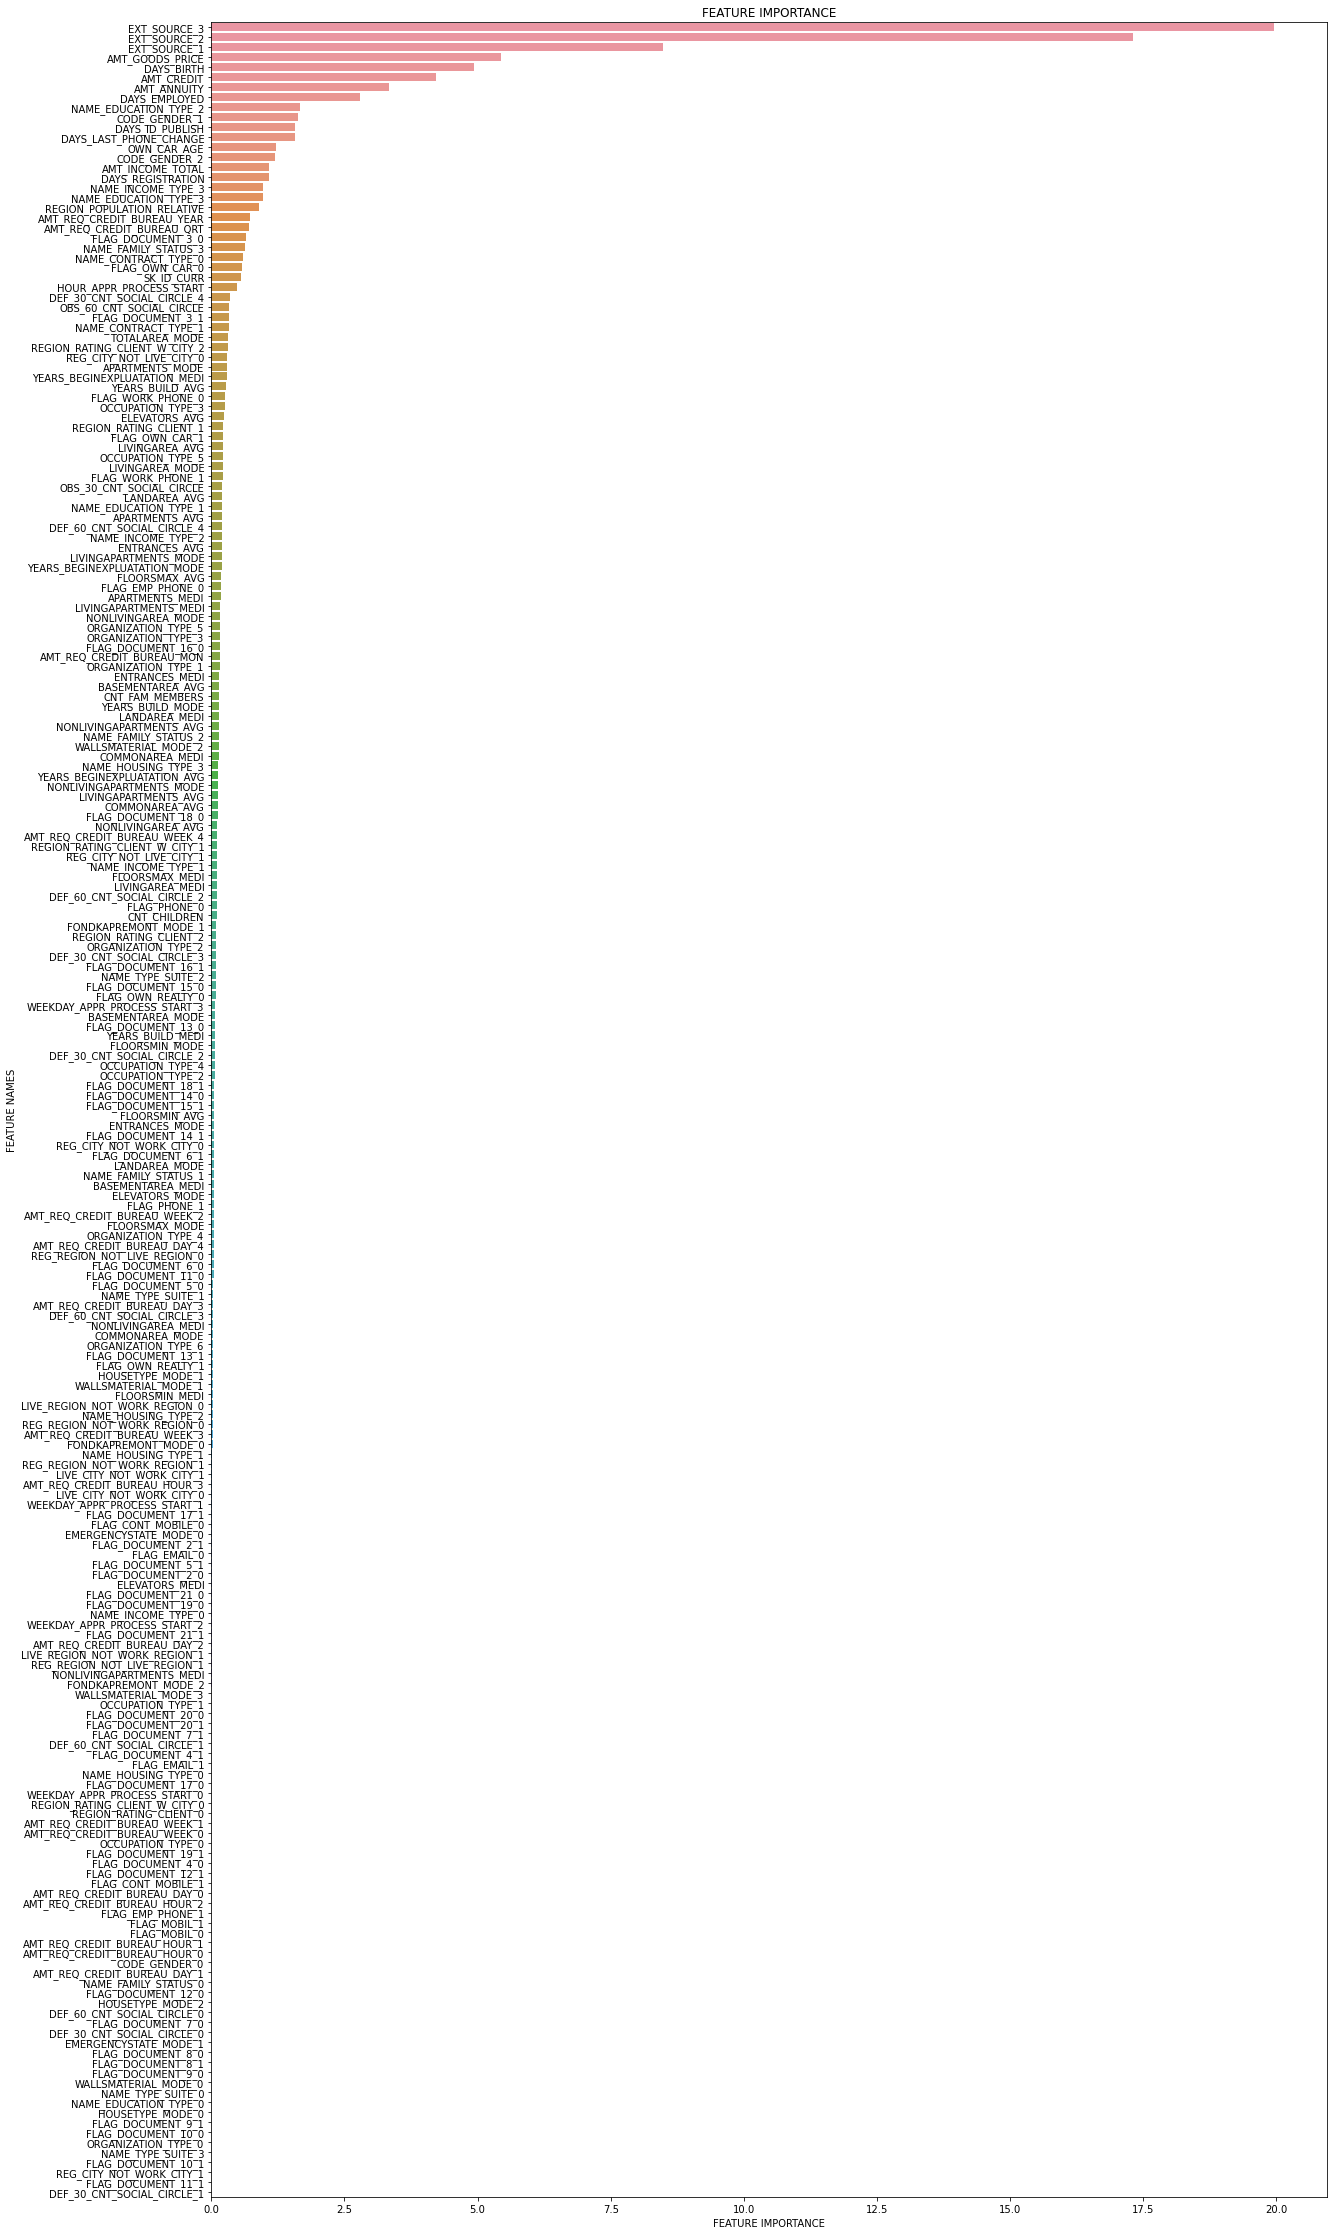

In [93]:
import seaborn as sns
plt.figure(figsize=(20,40))
sns.barplot(x=importance_df['feature_importance'], y=importance_df['feature_names'])
plt.title( 'FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

#### The most important features are  the external normalized scores, age and the price of the goods for which the loan is give.

# Stacking

In [164]:
def check_clf(X, y, clf):
        
    kf = KFold(n_splits=3, random_state=1, shuffle=True)
    
    roc_auc_list = []
        
    for i, (train_index, test_index) in enumerate(kf.split(X)):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(X_train, y_train)
        predict = clf.predict_proba(X_test)[:,1]
        roc_auc = roc_auc_score(y_test, predict)
        print(i, roc_auc)
        roc_auc_list.append(roc_auc)
              
    return np.mean(roc_auc_list)

In [165]:
cat_boost = CatBoostClassifier(num_trees =  1350, max_depth = 4, learning_rate = 0.06)
cross_val_catboost = check_clf(X, Y, cat_boost)

0:	learn: 0.6340817	total: 31.2ms	remaining: 42.2s
1:	learn: 0.5833384	total: 57.6ms	remaining: 38.8s
2:	learn: 0.5401091	total: 86.4ms	remaining: 38.8s
3:	learn: 0.5032735	total: 117ms	remaining: 39.2s
4:	learn: 0.4678849	total: 144ms	remaining: 38.7s
5:	learn: 0.4377250	total: 175ms	remaining: 39.2s
6:	learn: 0.4131350	total: 203ms	remaining: 38.9s
7:	learn: 0.3931030	total: 233ms	remaining: 39.1s
8:	learn: 0.3751455	total: 265ms	remaining: 39.5s
9:	learn: 0.3600595	total: 295ms	remaining: 39.6s
10:	learn: 0.3465559	total: 324ms	remaining: 39.5s
11:	learn: 0.3345132	total: 354ms	remaining: 39.4s
12:	learn: 0.3257509	total: 383ms	remaining: 39.4s
13:	learn: 0.3174484	total: 412ms	remaining: 39.3s
14:	learn: 0.3095471	total: 443ms	remaining: 39.4s
15:	learn: 0.3028550	total: 472ms	remaining: 39.4s
16:	learn: 0.2977609	total: 499ms	remaining: 39.2s
17:	learn: 0.2928332	total: 529ms	remaining: 39.2s
18:	learn: 0.2884182	total: 559ms	remaining: 39.2s
19:	learn: 0.2849155	total: 587ms	rema

In [166]:
cross_val_catboost

0.7593256616422557

In [167]:
cat_boost = CatBoostClassifier(num_trees =  1350, max_depth = 4, learning_rate = 0.06)

In [170]:
cat_boost.fit(X, Y)

0:	learn: 0.6314591	total: 56.3ms	remaining: 1m 15s
1:	learn: 0.5796172	total: 106ms	remaining: 1m 11s
2:	learn: 0.5329858	total: 161ms	remaining: 1m 12s
3:	learn: 0.4951298	total: 217ms	remaining: 1m 13s
4:	learn: 0.4631175	total: 267ms	remaining: 1m 11s
5:	learn: 0.4337544	total: 323ms	remaining: 1m 12s
6:	learn: 0.4095945	total: 381ms	remaining: 1m 13s
7:	learn: 0.3896535	total: 436ms	remaining: 1m 13s
8:	learn: 0.3727646	total: 490ms	remaining: 1m 12s
9:	learn: 0.3572729	total: 543ms	remaining: 1m 12s
10:	learn: 0.3445923	total: 606ms	remaining: 1m 13s
11:	learn: 0.3337196	total: 662ms	remaining: 1m 13s
12:	learn: 0.3240630	total: 716ms	remaining: 1m 13s
13:	learn: 0.3158723	total: 766ms	remaining: 1m 13s
14:	learn: 0.3086461	total: 820ms	remaining: 1m 12s
15:	learn: 0.3024448	total: 875ms	remaining: 1m 12s
16:	learn: 0.2969571	total: 931ms	remaining: 1m 12s
17:	learn: 0.2921825	total: 983ms	remaining: 1m 12s
18:	learn: 0.2879436	total: 1.03s	remaining: 1m 12s
19:	learn: 0.2842648	

In [172]:
submission = pd.read_csv("my_credit/sample_submission.csv")

In [173]:
prediction = cat_boost.predict_proba(test_data)[:,1]
submission['TARGET'] = prediction
submission.to_csv('sub1.csv', index=False)

In [178]:
!pip install lightgbm

In [179]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(objective='binary', random_state=42, n_estimators=1200, max_depth=4, learning_rate=0.05)

In [180]:
cross_val_xgboost = check_clf(X, Y, lgb)

0 0.759792517581864
1 0.7549377062795489
2 0.7543878852975484


In [183]:
cross_val_xgboost

0.7563727030529871

In [184]:
lgb_boost = LGBMClassifier(objective='binary', random_state=42, n_estimators=1200, max_depth=4, learning_rate=0.05)

In [185]:
lgb_boost.fit(X, Y)

LGBMClassifier(learning_rate=0.05, max_depth=4, n_estimators=1200,
               objective='binary', random_state=42)

In [186]:
submission = pd.read_csv("my_credit/sample_submission.csv")

In [187]:
prediction = lgb_boost.predict_proba(test_data)[:,1]
submission['TARGET'] = prediction
submission.to_csv('lgb_boost.csv', index=False)

In [210]:
from sklearn.linear_model import SGDClassifier
log_regr = SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=28, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [190]:
cross_val_log_reg = check_clf(X, Y, log_regr)

0 0.7364483363104648
1 0.7355654461890513
2 0.7374242450250099


In [191]:
cross_val_log_reg

0.7364793425081754

In [211]:
log_regr = SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=28, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [212]:
log_regr.fit(X,Y)

SGDClassifier(class_weight='balanced', loss='log', penalty='l1',
              random_state=28)

In [213]:
submission = pd.read_csv("my_credit/sample_submission.csv")
prediction = log_regr.predict_proba(test_data)[:,1]
submission['TARGET'] = prediction
submission.to_csv('log_regr.csv', index=False)


In [214]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 375, max_depth = 12, min_samples_leaf = 21, n_jobs = -1, verbose = 10)

In [215]:
cross_val_rf = check_clf(X, Y, rf)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 375
building tree 2 of 375
building tree 3 of 375
building tree 4 of 375building tree 5 of 375

building tree 6 of 375
building tree 7 of 375
building tree 8 of 375
building tree 9 of 375
building tree 10 of 375
building tree 11 of 375building tree 12 of 375
building tree 13 of 375

building tree 14 of 375
building tree 15 of 375
building tree 16 of 375


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.4s


building tree 17 of 375
building tree 18 of 375
building tree 19 of 375
building tree 20 of 375
building tree 21 of 375
building tree 22 of 375
building tree 23 of 375
building tree 24 of 375
building tree 25 of 375
building tree 26 of 375
building tree 27 of 375
building tree 28 of 375
building tree 29 of 375
building tree 30 of 375
building tree 31 of 375
building tree 32 of 375


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s


building tree 33 of 375
building tree 34 of 375
building tree 35 of 375
building tree 36 of 375
building tree 37 of 375
building tree 38 of 375
building tree 39 of 375
building tree 40 of 375
building tree 41 of 375
building tree 42 of 375
building tree 43 of 375
building tree 44 of 375
building tree 45 of 375
building tree 46 of 375
building tree 47 of 375
building tree 48 of 375


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s


building tree 49 of 375
building tree 50 of 375
building tree 51 of 375
building tree 52 of 375
building tree 53 of 375
building tree 54 of 375
building tree 55 of 375
building tree 56 of 375


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.0s


building tree 57 of 375
building tree 58 of 375
building tree 59 of 375
building tree 60 of 375
building tree 61 of 375
building tree 62 of 375
building tree 63 of 375
building tree 64 of 375


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.8s


building tree 65 of 375
building tree 66 of 375
building tree 67 of 375
building tree 68 of 375
building tree 69 of 375
building tree 70 of 375
building tree 71 of 375
building tree 72 of 375
building tree 73 of 375
building tree 74 of 375
building tree 75 of 375
building tree 76 of 375
building tree 77 of 375
building tree 78 of 375
building tree 79 of 375building tree 80 of 375



[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    6.0s


building tree 81 of 375
building tree 82 of 375
building tree 83 of 375
building tree 84 of 375
building tree 85 of 375
building tree 86 of 375
building tree 87 of 375
building tree 88 of 375
building tree 89 of 375
building tree 90 of 375
building tree 91 of 375
building tree 92 of 375
building tree 93 of 375


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    7.3s


building tree 94 of 375building tree 95 of 375

building tree 96 of 375
building tree 97 of 375
building tree 98 of 375
building tree 99 of 375
building tree 100 of 375
building tree 101 of 375
building tree 102 of 375
building tree 103 of 375
building tree 104 of 375


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    8.5s


building tree 105 of 375
building tree 106 of 375
building tree 107 of 375
building tree 108 of 375
building tree 109 of 375
building tree 110 of 375
building tree 111 of 375
building tree 112 of 375
building tree 113 of 375
building tree 114 of 375
building tree 115 of 375
building tree 116 of 375
building tree 117 of 375
building tree 118 of 375
building tree 119 of 375
building tree 120 of 375


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.6s


building tree 121 of 375
building tree 122 of 375
building tree 123 of 375
building tree 124 of 375
building tree 125 of 375
building tree 126 of 375
building tree 127 of 375
building tree 128 of 375
building tree 129 of 375
building tree 130 of 375
building tree 131 of 375
building tree 132 of 375
building tree 133 of 375
building tree 134 of 375
building tree 135 of 375
building tree 136 of 375
building tree 137 of 375


[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   11.1s


building tree 138 of 375
building tree 139 of 375
building tree 140 of 375
building tree 141 of 375
building tree 142 of 375
building tree 143 of 375
building tree 144 of 375
building tree 145 of 375
building tree 146 of 375
building tree 147 of 375
building tree 148 of 375
building tree 149 of 375
building tree 150 of 375
building tree 151 of 375
building tree 152 of 375
building tree 153 of 375
building tree 154 of 375
building tree 155 of 375


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.5s


building tree 156 of 375
building tree 157 of 375
building tree 158 of 375
building tree 159 of 375
building tree 160 of 375
building tree 161 of 375
building tree 162 of 375
building tree 163 of 375
building tree 164 of 375
building tree 165 of 375
building tree 166 of 375
building tree 167 of 375
building tree 168 of 375
building tree 169 of 375
building tree 170 of 375
building tree 171 of 375
building tree 172 of 375


[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   14.1s


building tree 173 of 375
building tree 174 of 375
building tree 175 of 375
building tree 176 of 375
building tree 177 of 375
building tree 178 of 375
building tree 179 of 375
building tree 180 of 375
building tree 181 of 375
building tree 182 of 375
building tree 183 of 375
building tree 184 of 375
building tree 185 of 375
building tree 186 of 375
building tree 187 of 375
building tree 188 of 375
building tree 189 of 375
building tree 190 of 375building tree 191 of 375

building tree 192 of 375
building tree 193 of 375
building tree 194 of 375

[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.6s



building tree 195 of 375
building tree 196 of 375
building tree 197 of 375
building tree 198 of 375
building tree 199 of 375
building tree 200 of 375
building tree 201 of 375
building tree 202 of 375
building tree 203 of 375
building tree 204 of 375
building tree 205 of 375
building tree 206 of 375
building tree 207 of 375
building tree 208 of 375
building tree 209 of 375
building tree 210 of 375
building tree 211 of 375
building tree 212 of 375
building tree 213 of 375


[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   17.4s


building tree 214 of 375
building tree 215 of 375
building tree 216 of 375
building tree 217 of 375
building tree 218 of 375
building tree 219 of 375
building tree 220 of 375
building tree 221 of 375
building tree 222 of 375
building tree 223 of 375
building tree 224 of 375
building tree 225 of 375
building tree 226 of 375
building tree 227 of 375
building tree 228 of 375
building tree 229 of 375
building tree 230 of 375
building tree 231 of 375
building tree 232 of 375
building tree 233 of 375
building tree 234 of 375


[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:   19.1s


building tree 235 of 375
building tree 236 of 375
building tree 237 of 375
building tree 238 of 375
building tree 239 of 375
building tree 240 of 375
building tree 241 of 375
building tree 242 of 375
building tree 243 of 375
building tree 244 of 375
building tree 245 of 375
building tree 246 of 375
building tree 247 of 375
building tree 248 of 375
building tree 249 of 375
building tree 250 of 375
building tree 251 of 375
building tree 252 of 375
building tree 253 of 375
building tree 254 of 375
building tree 255 of 375
building tree 256 of 375
building tree 257 of 375
building tree 258 of 375


[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:   21.2s


building tree 259 of 375
building tree 260 of 375
building tree 261 of 375
building tree 262 of 375
building tree 263 of 375
building tree 264 of 375
building tree 265 of 375
building tree 266 of 375
building tree 267 of 375
building tree 268 of 375
building tree 269 of 375
building tree 270 of 375
building tree 271 of 375
building tree 272 of 375
building tree 273 of 375
building tree 274 of 375
building tree 275 of 375
building tree 276 of 375
building tree 277 of 375
building tree 278 of 375
building tree 279 of 375
building tree 280 of 375


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   23.2s


building tree 281 of 375
building tree 282 of 375
building tree 283 of 375
building tree 284 of 375
building tree 285 of 375
building tree 286 of 375
building tree 287 of 375
building tree 288 of 375
building tree 289 of 375
building tree 290 of 375
building tree 291 of 375
building tree 292 of 375
building tree 293 of 375
building tree 294 of 375
building tree 295 of 375
building tree 296 of 375
building tree 297 of 375
building tree 298 of 375
building tree 299 of 375
building tree 300 of 375
building tree 301 of 375
building tree 302 of 375
building tree 303 of 375
building tree 304 of 375
building tree 305 of 375
building tree 306 of 375
building tree 307 of 375
building tree 308 of 375
building tree 309 of 375


[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:   25.3s


building tree 310 of 375
building tree 311 of 375
building tree 312 of 375
building tree 313 of 375
building tree 314 of 375
building tree 315 of 375
building tree 316 of 375
building tree 317 of 375
building tree 318 of 375
building tree 319 of 375
building tree 320 of 375
building tree 321 of 375
building tree 322 of 375building tree 323 of 375

building tree 324 of 375
building tree 325 of 375
building tree 326 of 375
building tree 327 of 375
building tree 328 of 375
building tree 329 of 375
building tree 330 of 375
building tree 331 of 375


[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   27.3s


building tree 332 of 375
building tree 333 of 375
building tree 334 of 375
building tree 335 of 375
building tree 336 of 375
building tree 337 of 375
building tree 338 of 375
building tree 339 of 375
building tree 340 of 375
building tree 341 of 375
building tree 342 of 375
building tree 343 of 375
building tree 344 of 375
building tree 345 of 375
building tree 346 of 375
building tree 347 of 375
building tree 348 of 375
building tree 349 of 375
building tree 350 of 375
building tree 351 of 375
building tree 352 of 375
building tree 353 of 375
building tree 354 of 375
building tree 355 of 375
building tree 356 of 375
building tree 357 of 375
building tree 358 of 375


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   29.4s


building tree 359 of 375
building tree 360 of 375
building tree 361 of 375
building tree 362 of 375
building tree 363 of 375
building tree 364 of 375
building tree 365 of 375
building tree 366 of 375
building tree 367 of 375
building tree 368 of 375
building tree 369 of 375
building tree 370 of 375
building tree 371 of 375
building tree 372 of 375
building tree 373 of 375
building tree 374 of 375
building tree 375 of 375


[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:   31.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    

0 0.7425769945414914


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 375
building tree 2 of 375
building tree 3 of 375
building tree 4 of 375
building tree 5 of 375
building tree 6 of 375
building tree 7 of 375
building tree 8 of 375
building tree 9 of 375
building tree 10 of 375
building tree 11 of 375
building tree 12 of 375
building tree 13 of 375
building tree 14 of 375
building tree 15 of 375
building tree 16 of 375


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.5s


building tree 17 of 375
building tree 18 of 375
building tree 19 of 375
building tree 20 of 375
building tree 21 of 375
building tree 22 of 375
building tree 23 of 375
building tree 24 of 375
building tree 25 of 375
building tree 26 of 375
building tree 27 of 375
building tree 28 of 375
building tree 29 of 375
building tree 30 of 375
building tree 31 of 375
building tree 32 of 375


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s


building tree 33 of 375
building tree 34 of 375
building tree 35 of 375
building tree 36 of 375
building tree 37 of 375
building tree 38 of 375
building tree 39 of 375
building tree 40 of 375
building tree 41 of 375
building tree 42 of 375
building tree 43 of 375
building tree 44 of 375
building tree 45 of 375
building tree 46 of 375
building tree 47 of 375


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s


building tree 48 of 375
building tree 49 of 375
building tree 50 of 375
building tree 51 of 375
building tree 52 of 375
building tree 53 of 375
building tree 54 of 375
building tree 55 of 375


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.2s


building tree 56 of 375
building tree 57 of 375
building tree 58 of 375
building tree 59 of 375
building tree 60 of 375
building tree 61 of 375
building tree 62 of 375
building tree 63 of 375
building tree 64 of 375


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.0s


building tree 65 of 375
building tree 66 of 375
building tree 67 of 375
building tree 68 of 375
building tree 69 of 375
building tree 70 of 375
building tree 71 of 375
building tree 72 of 375
building tree 73 of 375
building tree 74 of 375
building tree 75 of 375
building tree 76 of 375
building tree 77 of 375
building tree 78 of 375
building tree 79 of 375
building tree 80 of 375


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    6.2s


building tree 81 of 375
building tree 82 of 375
building tree 83 of 375
building tree 84 of 375
building tree 85 of 375
building tree 86 of 375
building tree 87 of 375
building tree 88 of 375
building tree 89 of 375


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    7.5s


building tree 90 of 375
building tree 91 of 375
building tree 92 of 375
building tree 93 of 375
building tree 94 of 375
building tree 95 of 375
building tree 96 of 375
building tree 97 of 375
building tree 98 of 375
building tree 99 of 375
building tree 100 of 375
building tree 101 of 375
building tree 102 of 375
building tree 103 of 375
building tree 104 of 375


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    8.6s


building tree 105 of 375
building tree 106 of 375
building tree 107 of 375
building tree 108 of 375
building tree 109 of 375
building tree 110 of 375
building tree 111 of 375
building tree 112 of 375
building tree 113 of 375
building tree 114 of 375
building tree 115 of 375
building tree 116 of 375
building tree 117 of 375
building tree 118 of 375
building tree 119 of 375
building tree 120 of 375


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.7s


building tree 121 of 375
building tree 122 of 375
building tree 123 of 375
building tree 124 of 375
building tree 125 of 375
building tree 126 of 375
building tree 127 of 375
building tree 128 of 375
building tree 129 of 375
building tree 130 of 375
building tree 131 of 375
building tree 132 of 375
building tree 133 of 375
building tree 134 of 375
building tree 135 of 375
building tree 136 of 375


[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   11.3s


building tree 137 of 375
building tree 138 of 375
building tree 139 of 375
building tree 140 of 375
building tree 141 of 375
building tree 142 of 375
building tree 143 of 375
building tree 144 of 375
building tree 145 of 375
building tree 146 of 375
building tree 147 of 375
building tree 148 of 375
building tree 149 of 375
building tree 150 of 375
building tree 151 of 375
building tree 152 of 375
building tree 153 of 375
building tree 154 of 375


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.8s


building tree 155 of 375
building tree 156 of 375
building tree 157 of 375
building tree 158 of 375
building tree 159 of 375
building tree 160 of 375
building tree 161 of 375
building tree 162 of 375
building tree 163 of 375
building tree 164 of 375
building tree 165 of 375
building tree 166 of 375
building tree 167 of 375
building tree 168 of 375
building tree 169 of 375
building tree 170 of 375
building tree 171 of 375
building tree 172 of 375
building tree 173 of 375


[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   14.4s


building tree 174 of 375
building tree 175 of 375
building tree 176 of 375
building tree 177 of 375
building tree 178 of 375
building tree 179 of 375
building tree 180 of 375
building tree 181 of 375
building tree 182 of 375
building tree 183 of 375
building tree 184 of 375
building tree 185 of 375
building tree 186 of 375
building tree 187 of 375
building tree 188 of 375
building tree 189 of 375
building tree 190 of 375
building tree 191 of 375


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.8s


building tree 192 of 375
building tree 193 of 375
building tree 194 of 375
building tree 195 of 375
building tree 196 of 375
building tree 197 of 375
building tree 198 of 375
building tree 199 of 375
building tree 200 of 375
building tree 201 of 375
building tree 202 of 375
building tree 203 of 375
building tree 204 of 375
building tree 205 of 375
building tree 206 of 375
building tree 207 of 375
building tree 208 of 375
building tree 209 of 375
building tree 210 of 375
building tree 211 of 375
building tree 212 of 375
building tree 213 of 375
building tree 214 of 375
building tree 215 of 375
building tree 216 of 375


[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   17.7s


building tree 217 of 375
building tree 218 of 375
building tree 219 of 375
building tree 220 of 375
building tree 221 of 375
building tree 222 of 375
building tree 223 of 375
building tree 224 of 375
building tree 225 of 375
building tree 226 of 375
building tree 227 of 375
building tree 228 of 375
building tree 229 of 375
building tree 230 of 375
building tree 231 of 375
building tree 232 of 375
building tree 233 of 375
building tree 234 of 375
building tree 235 of 375
building tree 236 of 375


[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:   19.4s


building tree 237 of 375
building tree 238 of 375
building tree 239 of 375
building tree 240 of 375
building tree 241 of 375
building tree 242 of 375
building tree 243 of 375
building tree 244 of 375
building tree 245 of 375
building tree 246 of 375
building tree 247 of 375
building tree 248 of 375
building tree 249 of 375
building tree 250 of 375
building tree 251 of 375
building tree 252 of 375
building tree 253 of 375
building tree 254 of 375
building tree 255 of 375
building tree 256 of 375


[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:   21.3s


building tree 257 of 375
building tree 258 of 375
building tree 259 of 375
building tree 260 of 375
building tree 261 of 375
building tree 262 of 375
building tree 263 of 375
building tree 264 of 375
building tree 265 of 375
building tree 266 of 375
building tree 267 of 375
building tree 268 of 375
building tree 269 of 375
building tree 270 of 375
building tree 271 of 375
building tree 272 of 375
building tree 273 of 375
building tree 274 of 375
building tree 275 of 375
building tree 276 of 375
building tree 277 of 375
building tree 278 of 375
building tree 279 of 375
building tree 280 of 375
building tree 281 of 375
building tree 282 of 375
building tree 283 of 375
building tree 284 of 375


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   23.2s


building tree 285 of 375
building tree 286 of 375
building tree 287 of 375
building tree 288 of 375
building tree 289 of 375
building tree 290 of 375
building tree 291 of 375
building tree 292 of 375
building tree 293 of 375
building tree 294 of 375
building tree 295 of 375
building tree 296 of 375
building tree 297 of 375
building tree 298 of 375
building tree 299 of 375
building tree 300 of 375
building tree 301 of 375
building tree 302 of 375
building tree 303 of 375
building tree 304 of 375
building tree 305 of 375


[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:   25.2s


building tree 306 of 375
building tree 307 of 375
building tree 308 of 375
building tree 309 of 375
building tree 310 of 375
building tree 311 of 375
building tree 312 of 375
building tree 313 of 375
building tree 314 of 375
building tree 315 of 375
building tree 316 of 375
building tree 317 of 375
building tree 318 of 375
building tree 319 of 375
building tree 320 of 375
building tree 321 of 375
building tree 322 of 375
building tree 323 of 375
building tree 324 of 375
building tree 325 of 375
building tree 326 of 375
building tree 327 of 375
building tree 328 of 375
building tree 329 of 375
building tree 330 of 375
building tree 331 of 375
building tree 332 of 375
building tree 333 of 375


[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   27.3s


building tree 334 of 375
building tree 335 of 375
building tree 336 of 375
building tree 337 of 375
building tree 338 of 375
building tree 339 of 375
building tree 340 of 375
building tree 341 of 375
building tree 342 of 375
building tree 343 of 375
building tree 344 of 375
building tree 345 of 375
building tree 346 of 375
building tree 347 of 375
building tree 348 of 375
building tree 349 of 375
building tree 350 of 375
building tree 351 of 375
building tree 352 of 375
building tree 353 of 375
building tree 354 of 375
building tree 355 of 375
building tree 356 of 375
building tree 357 of 375
building tree 358 of 375
building tree 359 of 375
building tree 360 of 375


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   29.5s


building tree 361 of 375
building tree 362 of 375
building tree 363 of 375
building tree 364 of 375
building tree 365 of 375
building tree 366 of 375
building tree 367 of 375
building tree 368 of 375
building tree 369 of 375
building tree 370 of 375
building tree 371 of 375
building tree 372 of 375
building tree 373 of 375
building tree 374 of 375
building tree 375 of 375


[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:   31.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    

1 0.7354980883988808


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 375
building tree 2 of 375
building tree 3 of 375building tree 4 of 375

building tree 5 of 375building tree 6 of 375
building tree 7 of 375
building tree 8 of 375

building tree 9 of 375
building tree 10 of 375
building tree 11 of 375
building tree 12 of 375
building tree 13 of 375
building tree 14 of 375
building tree 15 of 375
building tree 16 of 375


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.4s


building tree 17 of 375
building tree 18 of 375
building tree 19 of 375
building tree 20 of 375
building tree 21 of 375
building tree 22 of 375
building tree 23 of 375building tree 24 of 375

building tree 25 of 375
building tree 26 of 375
building tree 27 of 375
building tree 28 of 375
building tree 29 of 375
building tree 30 of 375
building tree 31 of 375
building tree 32 of 375


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s


building tree 33 of 375
building tree 34 of 375
building tree 35 of 375
building tree 36 of 375
building tree 37 of 375
building tree 38 of 375
building tree 39 of 375
building tree 40 of 375
building tree 41 of 375
building tree 42 of 375
building tree 43 of 375
building tree 44 of 375
building tree 45 of 375
building tree 46 of 375
building tree 47 of 375


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s


building tree 48 of 375
building tree 49 of 375
building tree 50 of 375
building tree 51 of 375
building tree 52 of 375
building tree 53 of 375
building tree 54 of 375
building tree 55 of 375


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.1s


building tree 56 of 375
building tree 57 of 375building tree 58 of 375

building tree 59 of 375
building tree 60 of 375
building tree 61 of 375
building tree 62 of 375
building tree 63 of 375
building tree 64 of 375


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.9s


building tree 65 of 375
building tree 66 of 375
building tree 67 of 375
building tree 68 of 375
building tree 69 of 375
building tree 70 of 375
building tree 71 of 375
building tree 72 of 375
building tree 73 of 375
building tree 74 of 375
building tree 75 of 375
building tree 76 of 375


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    6.3s


building tree 77 of 375
building tree 78 of 375
building tree 79 of 375
building tree 80 of 375
building tree 81 of 375
building tree 82 of 375
building tree 83 of 375
building tree 84 of 375
building tree 85 of 375
building tree 86 of 375
building tree 87 of 375
building tree 88 of 375
building tree 89 of 375
building tree 90 of 375
building tree 91 of 375
building tree 92 of 375
building tree 93 of 375


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    7.4s


building tree 94 of 375
building tree 95 of 375
building tree 96 of 375
building tree 97 of 375
building tree 98 of 375
building tree 99 of 375
building tree 100 of 375
building tree 101 of 375
building tree 102 of 375
building tree 103 of 375
building tree 104 of 375


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    8.7s


building tree 105 of 375
building tree 106 of 375
building tree 107 of 375
building tree 108 of 375
building tree 109 of 375
building tree 110 of 375
building tree 111 of 375
building tree 112 of 375
building tree 113 of 375
building tree 114 of 375
building tree 115 of 375
building tree 116 of 375
building tree 117 of 375
building tree 118 of 375
building tree 119 of 375
building tree 120 of 375


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.7s


building tree 121 of 375
building tree 122 of 375
building tree 123 of 375
building tree 124 of 375
building tree 125 of 375
building tree 126 of 375
building tree 127 of 375
building tree 128 of 375
building tree 129 of 375
building tree 130 of 375
building tree 131 of 375
building tree 132 of 375
building tree 133 of 375
building tree 134 of 375
building tree 135 of 375
building tree 136 of 375
building tree 137 of 375
building tree 138 of 375
building tree 139 of 375
building tree 140 of 375
building tree 141 of 375


[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   11.4s


building tree 142 of 375
building tree 143 of 375
building tree 144 of 375
building tree 145 of 375
building tree 146 of 375
building tree 147 of 375
building tree 148 of 375
building tree 149 of 375
building tree 150 of 375
building tree 151 of 375
building tree 152 of 375
building tree 153 of 375
building tree 154 of 375
building tree 155 of 375
building tree 156 of 375
building tree 157 of 375
building tree 158 of 375


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.8s


building tree 159 of 375
building tree 160 of 375
building tree 161 of 375
building tree 162 of 375
building tree 163 of 375
building tree 164 of 375
building tree 165 of 375
building tree 166 of 375
building tree 167 of 375
building tree 168 of 375
building tree 169 of 375
building tree 170 of 375
building tree 171 of 375
building tree 172 of 375


[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   14.3s


building tree 173 of 375
building tree 174 of 375
building tree 175 of 375
building tree 176 of 375
building tree 177 of 375
building tree 178 of 375
building tree 179 of 375
building tree 180 of 375
building tree 181 of 375
building tree 182 of 375
building tree 183 of 375
building tree 184 of 375
building tree 185 of 375
building tree 186 of 375
building tree 187 of 375
building tree 188 of 375
building tree 189 of 375
building tree 190 of 375
building tree 191 of 375
building tree 192 of 375


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.8s


building tree 193 of 375
building tree 194 of 375
building tree 195 of 375
building tree 196 of 375
building tree 197 of 375
building tree 198 of 375
building tree 199 of 375
building tree 200 of 375
building tree 201 of 375
building tree 202 of 375
building tree 203 of 375
building tree 204 of 375building tree 205 of 375

building tree 206 of 375
building tree 207 of 375
building tree 208 of 375
building tree 209 of 375
building tree 210 of 375
building tree 211 of 375
building tree 212 of 375
building tree 213 of 375


[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   17.7s


building tree 214 of 375
building tree 215 of 375
building tree 216 of 375
building tree 217 of 375
building tree 218 of 375
building tree 219 of 375
building tree 220 of 375
building tree 221 of 375
building tree 222 of 375
building tree 223 of 375
building tree 224 of 375
building tree 225 of 375
building tree 226 of 375
building tree 227 of 375
building tree 228 of 375
building tree 229 of 375
building tree 230 of 375
building tree 231 of 375
building tree 232 of 375
building tree 233 of 375
building tree 234 of 375
building tree 235 of 375
building tree 236 of 375
building tree 237 of 375
building tree 238 of 375


[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:   19.7s


building tree 239 of 375
building tree 240 of 375
building tree 241 of 375
building tree 242 of 375
building tree 243 of 375
building tree 244 of 375
building tree 245 of 375
building tree 246 of 375
building tree 247 of 375
building tree 248 of 375
building tree 249 of 375
building tree 250 of 375
building tree 251 of 375
building tree 252 of 375
building tree 253 of 375
building tree 254 of 375
building tree 255 of 375
building tree 256 of 375


[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:   21.5s


building tree 257 of 375
building tree 258 of 375
building tree 259 of 375
building tree 260 of 375
building tree 261 of 375
building tree 262 of 375
building tree 263 of 375
building tree 264 of 375
building tree 265 of 375
building tree 266 of 375
building tree 267 of 375
building tree 268 of 375
building tree 269 of 375
building tree 270 of 375
building tree 271 of 375
building tree 272 of 375
building tree 273 of 375
building tree 274 of 375
building tree 275 of 375
building tree 276 of 375
building tree 277 of 375
building tree 278 of 375
building tree 279 of 375
building tree 280 of 375


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   23.3s


building tree 281 of 375
building tree 282 of 375
building tree 283 of 375
building tree 284 of 375
building tree 285 of 375
building tree 286 of 375
building tree 287 of 375
building tree 288 of 375
building tree 289 of 375
building tree 290 of 375
building tree 291 of 375
building tree 292 of 375
building tree 293 of 375
building tree 294 of 375
building tree 295 of 375
building tree 296 of 375
building tree 297 of 375
building tree 298 of 375
building tree 299 of 375
building tree 300 of 375
building tree 301 of 375
building tree 302 of 375
building tree 303 of 375
building tree 304 of 375
building tree 305 of 375
building tree 306 of 375
building tree 307 of 375


[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:   25.5s


building tree 308 of 375
building tree 309 of 375
building tree 310 of 375
building tree 311 of 375
building tree 312 of 375
building tree 313 of 375
building tree 314 of 375
building tree 315 of 375
building tree 316 of 375
building tree 317 of 375
building tree 318 of 375
building tree 319 of 375
building tree 320 of 375
building tree 321 of 375
building tree 322 of 375
building tree 323 of 375
building tree 324 of 375
building tree 325 of 375
building tree 326 of 375
building tree 327 of 375
building tree 328 of 375
building tree 329 of 375
building tree 330 of 375
building tree 331 of 375


[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   27.5s


building tree 332 of 375
building tree 333 of 375
building tree 334 of 375
building tree 335 of 375
building tree 336 of 375
building tree 337 of 375
building tree 338 of 375
building tree 339 of 375
building tree 340 of 375
building tree 341 of 375
building tree 342 of 375
building tree 343 of 375
building tree 344 of 375
building tree 345 of 375
building tree 346 of 375
building tree 347 of 375
building tree 348 of 375
building tree 349 of 375
building tree 350 of 375
building tree 351 of 375
building tree 352 of 375
building tree 353 of 375
building tree 354 of 375
building tree 355 of 375
building tree 356 of 375
building tree 357 of 375
building tree 358 of 375


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   29.7s


building tree 359 of 375
building tree 360 of 375
building tree 361 of 375
building tree 362 of 375
building tree 363 of 375
building tree 364 of 375
building tree 365 of 375
building tree 366 of 375
building tree 367 of 375
building tree 368 of 375
building tree 369 of 375
building tree 370 of 375
building tree 371 of 375
building tree 372 of 375
building tree 373 of 375
building tree 374 of 375
building tree 375 of 375


[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:   31.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    

2 0.7356469853630684


In [216]:
cross_val_rf

0.7379073561011468

In [217]:
rf = RandomForestClassifier(n_estimators = 375, max_depth = 12, min_samples_leaf = 21, n_jobs = -1, verbose = 10)

In [218]:
rf.fit(X,Y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 375
building tree 2 of 375
building tree 3 of 375
building tree 4 of 375
building tree 5 of 375
building tree 6 of 375
building tree 7 of 375
building tree 8 of 375
building tree 9 of 375
building tree 10 of 375
building tree 11 of 375
building tree 12 of 375
building tree 13 of 375
building tree 14 of 375
building tree 15 of 375
building tree 16 of 375


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.1s


building tree 17 of 375
building tree 18 of 375
building tree 19 of 375
building tree 20 of 375
building tree 21 of 375
building tree 22 of 375
building tree 23 of 375


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s


building tree 24 of 375
building tree 25 of 375
building tree 26 of 375
building tree 27 of 375
building tree 28 of 375
building tree 29 of 375
building tree 30 of 375
building tree 31 of 375
building tree 32 of 375


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.3s


building tree 33 of 375
building tree 34 of 375
building tree 35 of 375
building tree 36 of 375
building tree 37 of 375
building tree 38 of 375
building tree 39 of 375
building tree 40 of 375
building tree 41 of 375
building tree 42 of 375
building tree 43 of 375
building tree 44 of 375
building tree 45 of 375


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s


building tree 46 of 375
building tree 47 of 375
building tree 48 of 375
building tree 49 of 375
building tree 50 of 375
building tree 51 of 375
building tree 52 of 375
building tree 53 of 375


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    6.7s


building tree 54 of 375
building tree 55 of 375
building tree 56 of 375
building tree 57 of 375
building tree 58 of 375
building tree 59 of 375
building tree 60 of 375
building tree 61 of 375
building tree 62 of 375
building tree 63 of 375
building tree 64 of 375


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    8.0s


building tree 65 of 375
building tree 66 of 375
building tree 67 of 375
building tree 68 of 375
building tree 69 of 375
building tree 70 of 375
building tree 71 of 375
building tree 72 of 375
building tree 73 of 375
building tree 74 of 375
building tree 75 of 375
building tree 76 of 375
building tree 77 of 375


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   10.0s


building tree 78 of 375
building tree 79 of 375
building tree 80 of 375
building tree 81 of 375
building tree 82 of 375
building tree 83 of 375
building tree 84 of 375
building tree 85 of 375
building tree 86 of 375
building tree 87 of 375
building tree 88 of 375
building tree 89 of 375
building tree 90 of 375
building tree 91 of 375
building tree 92 of 375
building tree 93 of 375


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   12.0s


building tree 94 of 375
building tree 95 of 375
building tree 96 of 375
building tree 97 of 375
building tree 98 of 375
building tree 99 of 375
building tree 100 of 375
building tree 101 of 375
building tree 102 of 375
building tree 103 of 375
building tree 104 of 375


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   14.0s


building tree 105 of 375
building tree 106 of 375
building tree 107 of 375
building tree 108 of 375
building tree 109 of 375
building tree 110 of 375
building tree 111 of 375
building tree 112 of 375
building tree 113 of 375
building tree 114 of 375
building tree 115 of 375
building tree 116 of 375
building tree 117 of 375
building tree 118 of 375
building tree 119 of 375


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   15.8s


building tree 120 of 375
building tree 121 of 375
building tree 122 of 375
building tree 123 of 375
building tree 124 of 375
building tree 125 of 375
building tree 126 of 375
building tree 127 of 375
building tree 128 of 375
building tree 129 of 375
building tree 130 of 375
building tree 131 of 375
building tree 132 of 375
building tree 133 of 375
building tree 134 of 375
building tree 135 of 375
building tree 136 of 375
building tree 137 of 375


[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   18.1s


building tree 138 of 375
building tree 139 of 375
building tree 140 of 375
building tree 141 of 375
building tree 142 of 375
building tree 143 of 375
building tree 144 of 375
building tree 145 of 375
building tree 146 of 375
building tree 147 of 375
building tree 148 of 375
building tree 149 of 375
building tree 150 of 375
building tree 151 of 375
building tree 152 of 375
building tree 153 of 375
building tree 154 of 375
building tree 155 of 375


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   20.6s


building tree 156 of 375
building tree 157 of 375
building tree 158 of 375
building tree 159 of 375
building tree 160 of 375
building tree 161 of 375
building tree 162 of 375
building tree 163 of 375
building tree 164 of 375
building tree 165 of 375
building tree 166 of 375
building tree 167 of 375
building tree 168 of 375
building tree 169 of 375
building tree 170 of 375
building tree 171 of 375
building tree 172 of 375
building tree 173 of 375
building tree 174 of 375
building tree 175 of 375


[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   23.3s


building tree 176 of 375
building tree 177 of 375
building tree 178 of 375
building tree 179 of 375
building tree 180 of 375
building tree 181 of 375
building tree 182 of 375
building tree 183 of 375
building tree 184 of 375
building tree 185 of 375
building tree 186 of 375
building tree 187 of 375
building tree 188 of 375
building tree 189 of 375
building tree 190 of 375
building tree 191 of 375


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.7s


building tree 192 of 375
building tree 193 of 375
building tree 194 of 375
building tree 195 of 375
building tree 196 of 375
building tree 197 of 375
building tree 198 of 375
building tree 199 of 375
building tree 200 of 375
building tree 201 of 375
building tree 202 of 375
building tree 203 of 375
building tree 204 of 375
building tree 205 of 375
building tree 206 of 375
building tree 207 of 375
building tree 208 of 375
building tree 209 of 375
building tree 210 of 375
building tree 211 of 375
building tree 212 of 375
building tree 213 of 375
building tree 214 of 375


[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   28.6s


building tree 215 of 375
building tree 216 of 375
building tree 217 of 375
building tree 218 of 375
building tree 219 of 375
building tree 220 of 375
building tree 221 of 375
building tree 222 of 375
building tree 223 of 375
building tree 224 of 375
building tree 225 of 375
building tree 226 of 375
building tree 227 of 375
building tree 228 of 375
building tree 229 of 375
building tree 230 of 375
building tree 231 of 375
building tree 232 of 375
building tree 233 of 375


[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:   31.5s


building tree 234 of 375
building tree 235 of 375
building tree 236 of 375
building tree 237 of 375
building tree 238 of 375
building tree 239 of 375
building tree 240 of 375
building tree 241 of 375
building tree 242 of 375
building tree 243 of 375
building tree 244 of 375
building tree 245 of 375
building tree 246 of 375
building tree 247 of 375
building tree 248 of 375
building tree 249 of 375
building tree 250 of 375
building tree 251 of 375
building tree 252 of 375
building tree 253 of 375
building tree 254 of 375
building tree 255 of 375
building tree 256 of 375
building tree 257 of 375


[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:   34.6s


building tree 258 of 375
building tree 259 of 375
building tree 260 of 375
building tree 261 of 375
building tree 262 of 375
building tree 263 of 375
building tree 264 of 375
building tree 265 of 375
building tree 266 of 375
building tree 267 of 375
building tree 268 of 375
building tree 269 of 375
building tree 270 of 375
building tree 271 of 375
building tree 272 of 375
building tree 273 of 375
building tree 274 of 375
building tree 275 of 375
building tree 276 of 375
building tree 277 of 375
building tree 278 of 375
building tree 279 of 375


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   37.7s


building tree 280 of 375
building tree 281 of 375
building tree 282 of 375
building tree 283 of 375
building tree 284 of 375
building tree 285 of 375
building tree 286 of 375
building tree 287 of 375
building tree 288 of 375
building tree 289 of 375
building tree 290 of 375
building tree 291 of 375
building tree 292 of 375
building tree 293 of 375
building tree 294 of 375
building tree 295 of 375
building tree 296 of 375
building tree 297 of 375
building tree 298 of 375
building tree 299 of 375
building tree 300 of 375
building tree 301 of 375
building tree 302 of 375
building tree 303 of 375
building tree 304 of 375


[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:   41.3s


building tree 305 of 375
building tree 306 of 375
building tree 307 of 375
building tree 308 of 375
building tree 309 of 375
building tree 310 of 375
building tree 311 of 375
building tree 312 of 375
building tree 313 of 375
building tree 314 of 375
building tree 315 of 375
building tree 316 of 375
building tree 317 of 375
building tree 318 of 375
building tree 319 of 375
building tree 320 of 375
building tree 321 of 375
building tree 322 of 375
building tree 323 of 375
building tree 324 of 375
building tree 325 of 375
building tree 326 of 375
building tree 327 of 375
building tree 328 of 375
building tree 329 of 375
building tree 330 of 375
building tree 331 of 375


[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   44.7s


building tree 332 of 375
building tree 333 of 375
building tree 334 of 375
building tree 335 of 375
building tree 336 of 375
building tree 337 of 375
building tree 338 of 375
building tree 339 of 375
building tree 340 of 375
building tree 341 of 375
building tree 342 of 375
building tree 343 of 375
building tree 344 of 375
building tree 345 of 375
building tree 346 of 375
building tree 347 of 375
building tree 348 of 375
building tree 349 of 375
building tree 350 of 375
building tree 351 of 375
building tree 352 of 375
building tree 353 of 375
building tree 354 of 375
building tree 355 of 375
building tree 356 of 375
building tree 357 of 375


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   48.0s


building tree 358 of 375
building tree 359 of 375
building tree 360 of 375
building tree 361 of 375
building tree 362 of 375
building tree 363 of 375
building tree 364 of 375building tree 365 of 375

building tree 366 of 375
building tree 367 of 375
building tree 368 of 375
building tree 369 of 375
building tree 370 of 375
building tree 371 of 375
building tree 372 of 375
building tree 373 of 375
building tree 374 of 375
building tree 375 of 375


[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:   51.3s finished


RandomForestClassifier(max_depth=12, min_samples_leaf=21, n_estimators=375,
                       n_jobs=-1, verbose=10)

In [219]:
submission = pd.read_csv("my_credit/sample_submission.csv")
prediction = rf.predict_proba(test_data)[:,1]
submission['TARGET'] = prediction
submission.to_csv('rf.csv', index=False)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Para

In [224]:
from sklearn.ensemble import GradientBoostingClassifier
rf2 = RandomForestClassifier(n_estimators = 500, max_depth = 16, min_samples_leaf = 25, n_jobs = -1, verbose = 10)

In [226]:
cross_val_rf2 = check_clf(X, Y, rf2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.7s


building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500building tree 24 of 500

building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500building tree 31 of 500

building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.2s


building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s


building tree 49 of 500building tree 50 of 500

building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.9s


building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.8s


building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    7.4s


building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    8.9s


building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   10.5s


building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500building tree 114 of 500

building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   11.5s


building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500


[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   13.6s


building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.3s


building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500


[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   17.1s


building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.9s


building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500
building tree 202 of 500
building tree 203 of 500building tree 204 of 500

building tree 205 of 500
building tree 206 of 500
building tree 207 of 500
building tree 208 of 500
building tree 209 of 500
building tree 210 of 500
building tree 211 of 500
building tree 212 of 500
building tree 213 of 500
building tree 214 of 500
building tree 215 of 500


[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   21.1s


building tree 216 of 500
building tree 217 of 500
building tree 218 of 500
building tree 219 of 500
building tree 220 of 500
building tree 221 of 500
building tree 222 of 500
building tree 223 of 500
building tree 224 of 500
building tree 225 of 500
building tree 226 of 500
building tree 227 of 500
building tree 228 of 500
building tree 229 of 500
building tree 230 of 500
building tree 231 of 500
building tree 232 of 500
building tree 233 of 500
building tree 234 of 500
building tree 235 of 500


[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:   23.4s


building tree 236 of 500
building tree 237 of 500
building tree 238 of 500
building tree 239 of 500
building tree 240 of 500
building tree 241 of 500
building tree 242 of 500
building tree 243 of 500
building tree 244 of 500
building tree 245 of 500
building tree 246 of 500
building tree 247 of 500
building tree 248 of 500
building tree 249 of 500
building tree 250 of 500
building tree 251 of 500
building tree 252 of 500
building tree 253 of 500
building tree 254 of 500
building tree 255 of 500
building tree 256 of 500


[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:   25.6s


building tree 257 of 500
building tree 258 of 500
building tree 259 of 500
building tree 260 of 500
building tree 261 of 500
building tree 262 of 500
building tree 263 of 500
building tree 264 of 500
building tree 265 of 500
building tree 266 of 500
building tree 267 of 500
building tree 268 of 500
building tree 269 of 500
building tree 270 of 500
building tree 271 of 500
building tree 272 of 500
building tree 273 of 500
building tree 274 of 500
building tree 275 of 500
building tree 276 of 500
building tree 277 of 500
building tree 278 of 500
building tree 279 of 500
building tree 280 of 500


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   27.8s


building tree 281 of 500
building tree 282 of 500
building tree 283 of 500
building tree 284 of 500
building tree 285 of 500
building tree 286 of 500
building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500


[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:   30.5s


building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500
building tree 327 of 500
building tree 328 of 500
building tree 329 of 500
building tree 330 of 500
building tree 331 of 500


[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   33.1s


building tree 332 of 500
building tree 333 of 500
building tree 334 of 500
building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   35.7s


building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500


[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   38.5s


building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500building tree 406 of 500

building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500


[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:   41.4s


building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500
building tree 443 of 500
building tree 444 of 500
building tree 445 of 500
building tree 446 of 500
building tree 447 of 500


[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   44.4s


building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500
building tree 452 of 500
building tree 453 of 500
building tree 454 of 500
building tree 455 of 500
building tree 456 of 500
building tree 457 of 500
building tree 458 of 500
building tree 459 of 500
building tree 460 of 500
building tree 461 of 500
building tree 462 of 500
building tree 463 of 500
building tree 464 of 500
building tree 465 of 500
building tree 466 of 500
building tree 467 of 500
building tree 468 of 500
building tree 469 of 500
building tree 470 of 500
building tree 471 of 500
building tree 472 of 500
building tree 473 of 500


[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:   47.6s


building tree 474 of 500
building tree 475 of 500
building tree 476 of 500
building tree 477 of 500
building tree 478 of 500
building tree 479 of 500
building tree 480 of 500
building tree 481 of 500
building tree 482 of 500
building tree 483 of 500
building tree 484 of 500
building tree 485 of 500
building tree 486 of 500
building tree 487 of 500
building tree 488 of 500
building tree 489 of 500
building tree 490 of 500
building tree 491 of 500
building tree 492 of 500
building tree 493 of 500
building tree 494 of 500
building tree 495 of 500
building tree 496 of 500
building tree 497 of 500
building tree 498 of 500
building tree 499 of 500
building tree 500 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   50.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    

0 0.7453831730701651


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s


building tree 16 of 500


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s


building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.8s


building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s


building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s


building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    5.0s


building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.9s


building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500building tree 79 of 500

building tree 80 of 500


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    7.4s


building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    9.0s


building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   10.6s


building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500building tree 112 of 500

building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   11.6s


building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500


[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   13.8s


building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.5s


building tree 157 of 500building tree 158 of 500

building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500


[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   17.2s


building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.0s


building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500
building tree 202 of 500
building tree 203 of 500
building tree 204 of 500
building tree 205 of 500
building tree 206 of 500
building tree 207 of 500
building tree 208 of 500
building tree 209 of 500
building tree 210 of 500
building tree 211 of 500
building tree 212 of 500
building tree 213 of 500


[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   21.2s


building tree 214 of 500
building tree 215 of 500
building tree 216 of 500
building tree 217 of 500
building tree 218 of 500
building tree 219 of 500
building tree 220 of 500
building tree 221 of 500
building tree 222 of 500
building tree 223 of 500
building tree 224 of 500
building tree 225 of 500
building tree 226 of 500
building tree 227 of 500
building tree 228 of 500
building tree 229 of 500
building tree 230 of 500
building tree 231 of 500
building tree 232 of 500
building tree 233 of 500
building tree 234 of 500
building tree 235 of 500
building tree 236 of 500
building tree 237 of 500
building tree 238 of 500
building tree 239 of 500


[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:   23.7s


building tree 240 of 500
building tree 241 of 500
building tree 242 of 500
building tree 243 of 500
building tree 244 of 500
building tree 245 of 500
building tree 246 of 500
building tree 247 of 500
building tree 248 of 500
building tree 249 of 500
building tree 250 of 500
building tree 251 of 500
building tree 252 of 500
building tree 253 of 500
building tree 254 of 500
building tree 255 of 500
building tree 256 of 500


[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:   26.1s


building tree 257 of 500
building tree 258 of 500
building tree 259 of 500
building tree 260 of 500
building tree 261 of 500
building tree 262 of 500
building tree 263 of 500
building tree 264 of 500
building tree 265 of 500
building tree 266 of 500
building tree 267 of 500
building tree 268 of 500
building tree 269 of 500
building tree 270 of 500
building tree 271 of 500
building tree 272 of 500
building tree 273 of 500
building tree 274 of 500
building tree 275 of 500
building tree 276 of 500
building tree 277 of 500
building tree 278 of 500
building tree 279 of 500
building tree 280 of 500


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   28.0s


building tree 281 of 500
building tree 282 of 500
building tree 283 of 500
building tree 284 of 500
building tree 285 of 500
building tree 286 of 500
building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500


[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:   30.9s


building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500
building tree 327 of 500
building tree 328 of 500
building tree 329 of 500
building tree 330 of 500


[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   33.4s


building tree 331 of 500
building tree 332 of 500
building tree 333 of 500
building tree 334 of 500
building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   36.1s


building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500building tree 383 of 500



[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   38.6s


building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500


[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:   41.7s


building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500
building tree 443 of 500


[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   44.7s


building tree 444 of 500
building tree 445 of 500
building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500
building tree 452 of 500
building tree 453 of 500
building tree 454 of 500
building tree 455 of 500
building tree 456 of 500
building tree 457 of 500
building tree 458 of 500
building tree 459 of 500
building tree 460 of 500
building tree 461 of 500
building tree 462 of 500
building tree 463 of 500
building tree 464 of 500
building tree 465 of 500
building tree 466 of 500
building tree 467 of 500
building tree 468 of 500
building tree 469 of 500
building tree 470 of 500
building tree 471 of 500
building tree 472 of 500


[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:   47.8s


building tree 473 of 500
building tree 474 of 500
building tree 475 of 500
building tree 476 of 500
building tree 477 of 500
building tree 478 of 500
building tree 479 of 500
building tree 480 of 500
building tree 481 of 500
building tree 482 of 500
building tree 483 of 500
building tree 484 of 500
building tree 485 of 500
building tree 486 of 500
building tree 487 of 500
building tree 488 of 500
building tree 489 of 500
building tree 490 of 500
building tree 491 of 500
building tree 492 of 500
building tree 493 of 500
building tree 494 of 500
building tree 495 of 500
building tree 496 of 500
building tree 497 of 500
building tree 498 of 500
building tree 499 of 500
building tree 500 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   51.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    

1 0.7385911516150137


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.7s


building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.2s


building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s


building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500building tree 55 of 500

building tree 56 of 500


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.9s


building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.8s


building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500building tree 74 of 500

building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    7.3s


building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    8.9s


building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   10.5s


building tree 105 of 500building tree 106 of 500

building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   11.5s


building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500


[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   13.6s


building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.3s


building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500building tree 173 of 500

building tree 174 of 500
building tree 175 of 500
building tree 176 of 500


[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   17.2s


building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.9s


building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500
building tree 202 of 500
building tree 203 of 500
building tree 204 of 500
building tree 205 of 500
building tree 206 of 500
building tree 207 of 500
building tree 208 of 500
building tree 209 of 500
building tree 210 of 500
building tree 211 of 500
building tree 212 of 500
building tree 213 of 500
building tree 214 of 500
building tree 215 of 500
building tree 216 of 500


[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   21.2s


building tree 217 of 500
building tree 218 of 500
building tree 219 of 500
building tree 220 of 500
building tree 221 of 500
building tree 222 of 500
building tree 223 of 500
building tree 224 of 500
building tree 225 of 500
building tree 226 of 500
building tree 227 of 500
building tree 228 of 500
building tree 229 of 500
building tree 230 of 500
building tree 231 of 500
building tree 232 of 500
building tree 233 of 500


[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:   23.5s


building tree 234 of 500
building tree 235 of 500
building tree 236 of 500
building tree 237 of 500
building tree 238 of 500
building tree 239 of 500
building tree 240 of 500
building tree 241 of 500
building tree 242 of 500
building tree 243 of 500
building tree 244 of 500
building tree 245 of 500
building tree 246 of 500
building tree 247 of 500
building tree 248 of 500
building tree 249 of 500
building tree 250 of 500
building tree 251 of 500
building tree 252 of 500
building tree 253 of 500
building tree 254 of 500
building tree 255 of 500
building tree 256 of 500


[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:   25.6s


building tree 257 of 500
building tree 258 of 500
building tree 259 of 500
building tree 260 of 500
building tree 261 of 500
building tree 262 of 500
building tree 263 of 500
building tree 264 of 500
building tree 265 of 500
building tree 266 of 500
building tree 267 of 500
building tree 268 of 500
building tree 269 of 500
building tree 270 of 500
building tree 271 of 500
building tree 272 of 500
building tree 273 of 500
building tree 274 of 500
building tree 275 of 500
building tree 276 of 500
building tree 277 of 500
building tree 278 of 500
building tree 279 of 500
building tree 280 of 500


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   27.8s


building tree 281 of 500
building tree 282 of 500
building tree 283 of 500
building tree 284 of 500
building tree 285 of 500
building tree 286 of 500
building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500


[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:   30.4s


building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500
building tree 327 of 500
building tree 328 of 500
building tree 329 of 500


[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   33.1s


building tree 330 of 500
building tree 331 of 500
building tree 332 of 500
building tree 333 of 500
building tree 334 of 500
building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   35.7s


building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500


[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   38.4s


building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500


[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:   41.3s


building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500


[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   44.5s


building tree 442 of 500
building tree 443 of 500
building tree 444 of 500
building tree 445 of 500
building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500
building tree 452 of 500
building tree 453 of 500
building tree 454 of 500
building tree 455 of 500
building tree 456 of 500
building tree 457 of 500
building tree 458 of 500
building tree 459 of 500
building tree 460 of 500
building tree 461 of 500
building tree 462 of 500
building tree 463 of 500
building tree 464 of 500
building tree 465 of 500
building tree 466 of 500
building tree 467 of 500
building tree 468 of 500
building tree 469 of 500
building tree 470 of 500
building tree 471 of 500
building tree 472 of 500
building tree 473 of 500


[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:   47.4s


building tree 474 of 500
building tree 475 of 500
building tree 476 of 500
building tree 477 of 500
building tree 478 of 500
building tree 479 of 500
building tree 480 of 500
building tree 481 of 500
building tree 482 of 500
building tree 483 of 500
building tree 484 of 500
building tree 485 of 500
building tree 486 of 500
building tree 487 of 500
building tree 488 of 500
building tree 489 of 500
building tree 490 of 500
building tree 491 of 500
building tree 492 of 500
building tree 493 of 500
building tree 494 of 500
building tree 495 of 500
building tree 496 of 500
building tree 497 of 500
building tree 498 of 500
building tree 499 of 500
building tree 500 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   50.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    

2 0.7403831861477779


[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.5s finished


In [227]:
cross_val_rf2

0.7414525036109856

In [228]:
rf2 = RandomForestClassifier(n_estimators = 500, max_depth = 16, min_samples_leaf = 25, n_jobs = -1, verbose = 10)

In [231]:
rf2.fit(X,Y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s


building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.9s


building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.4s


building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s


building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    8.3s


building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.9s


building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   12.4s


building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   14.8s


building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   17.3s


building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   19.6s


building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500


[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   22.6s


building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   25.4s


building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500


[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   28.7s


building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.9s


building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500
building tree 202 of 500
building tree 203 of 500
building tree 204 of 500
building tree 205 of 500
building tree 206 of 500
building tree 207 of 500
building tree 208 of 500
building tree 209 of 500
building tree 210 of 500
building tree 211 of 500
building tree 212 of 500


[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   35.5s


building tree 213 of 500
building tree 214 of 500
building tree 215 of 500
building tree 216 of 500
building tree 217 of 500
building tree 218 of 500
building tree 219 of 500
building tree 220 of 500
building tree 221 of 500
building tree 222 of 500
building tree 223 of 500
building tree 224 of 500
building tree 225 of 500
building tree 226 of 500
building tree 227 of 500
building tree 228 of 500
building tree 229 of 500
building tree 230 of 500
building tree 231 of 500
building tree 232 of 500
building tree 233 of 500


[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:   39.1s


building tree 234 of 500
building tree 235 of 500
building tree 236 of 500
building tree 237 of 500
building tree 238 of 500
building tree 239 of 500
building tree 240 of 500
building tree 241 of 500
building tree 242 of 500
building tree 243 of 500
building tree 244 of 500
building tree 245 of 500
building tree 246 of 500
building tree 247 of 500
building tree 248 of 500
building tree 249 of 500
building tree 250 of 500
building tree 251 of 500
building tree 252 of 500
building tree 253 of 500
building tree 254 of 500
building tree 255 of 500
building tree 256 of 500
building tree 257 of 500


[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:   42.9s


building tree 258 of 500
building tree 259 of 500
building tree 260 of 500
building tree 261 of 500
building tree 262 of 500
building tree 263 of 500
building tree 264 of 500
building tree 265 of 500
building tree 266 of 500
building tree 267 of 500
building tree 268 of 500
building tree 269 of 500
building tree 270 of 500
building tree 271 of 500
building tree 272 of 500
building tree 273 of 500
building tree 274 of 500
building tree 275 of 500
building tree 276 of 500
building tree 277 of 500
building tree 278 of 500
building tree 279 of 500
building tree 280 of 500
building tree 281 of 500


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   46.9s


building tree 282 of 500
building tree 283 of 500
building tree 284 of 500
building tree 285 of 500
building tree 286 of 500
building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500


[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:   51.1s


building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500
building tree 327 of 500
building tree 328 of 500
building tree 329 of 500


[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   55.4s


building tree 330 of 500
building tree 331 of 500
building tree 332 of 500
building tree 333 of 500
building tree 334 of 500
building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.0min


building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500


[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  1.1min


building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500


[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  1.2min


building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500


[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min


building tree 443 of 500
building tree 444 of 500
building tree 445 of 500
building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500
building tree 452 of 500
building tree 453 of 500
building tree 454 of 500
building tree 455 of 500
building tree 456 of 500
building tree 457 of 500
building tree 458 of 500
building tree 459 of 500
building tree 460 of 500
building tree 461 of 500
building tree 462 of 500
building tree 463 of 500
building tree 464 of 500
building tree 465 of 500
building tree 466 of 500
building tree 467 of 500
building tree 468 of 500
building tree 469 of 500
building tree 470 of 500
building tree 471 of 500
building tree 472 of 500


[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:  1.3min


building tree 473 of 500
building tree 474 of 500
building tree 475 of 500
building tree 476 of 500
building tree 477 of 500
building tree 478 of 500
building tree 479 of 500
building tree 480 of 500
building tree 481 of 500
building tree 482 of 500
building tree 483 of 500
building tree 484 of 500
building tree 485 of 500
building tree 486 of 500
building tree 487 of 500
building tree 488 of 500
building tree 489 of 500
building tree 490 of 500
building tree 491 of 500
building tree 492 of 500
building tree 493 of 500
building tree 494 of 500
building tree 495 of 500
building tree 496 of 500
building tree 497 of 500
building tree 498 of 500
building tree 499 of 500
building tree 500 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished


RandomForestClassifier(max_depth=16, min_samples_leaf=25, n_estimators=500,
                       n_jobs=-1, verbose=10)

In [232]:
submission = pd.read_csv("my_credit/sample_submission.csv")
prediction = rf2.predict_proba(test_data)[:,1]
submission['TARGET'] = prediction
submission.to_csv('rf2.csv', index=False)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Para

# Stacking model

In [236]:
classifiers = [ ('catboost', CatBoostClassifier(num_trees =  1350, max_depth = 4, learning_rate = 0.06)),
                ('lgbm', LGBMClassifier(objective='binary', random_state=42, n_estimators=1200, max_depth=4, learning_rate=0.05)),
                ('rf', RandomForestClassifier(n_estimators = 375, max_depth = 12, min_samples_leaf = 21)),
                ('rf2', RandomForestClassifier(n_estimators = 500, max_depth = 16, min_samples_leaf = 25) ),
                ('log_reg', SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=28, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False) )]

In [237]:
from sklearn.ensemble import StackingClassifier
stacking_mod = StackingClassifier(estimators=classifiers, final_estimator=CatBoostClassifier(), verbose=10)

In [238]:
stacking_mod.fit(X,Y)

0:	learn: 0.6314591	total: 46.2ms	remaining: 1m 2s
1:	learn: 0.5796172	total: 84.2ms	remaining: 56.8s
2:	learn: 0.5329858	total: 128ms	remaining: 57.5s
3:	learn: 0.4951298	total: 170ms	remaining: 57.2s
4:	learn: 0.4631175	total: 208ms	remaining: 56.1s
5:	learn: 0.4337544	total: 255ms	remaining: 57.1s
6:	learn: 0.4095945	total: 300ms	remaining: 57.5s
7:	learn: 0.3896535	total: 340ms	remaining: 57.1s
8:	learn: 0.3727646	total: 382ms	remaining: 56.9s
9:	learn: 0.3572729	total: 425ms	remaining: 56.9s
10:	learn: 0.3445923	total: 473ms	remaining: 57.5s
11:	learn: 0.3337196	total: 515ms	remaining: 57.4s
12:	learn: 0.3240630	total: 557ms	remaining: 57.3s
13:	learn: 0.3158723	total: 597ms	remaining: 57s
14:	learn: 0.3086461	total: 641ms	remaining: 57s
15:	learn: 0.3024448	total: 684ms	remaining: 57s
16:	learn: 0.2969571	total: 726ms	remaining: 56.9s
17:	learn: 0.2921825	total: 768ms	remaining: 56.8s
18:	learn: 0.2879436	total: 808ms	remaining: 56.6s
19:	learn: 0.2842648	total: 846ms	remaining: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 0.6344157	total: 31.2ms	remaining: 42s
1:	learn: 0.5818134	total: 66ms	remaining: 44.5s
2:	learn: 0.5390353	total: 101ms	remaining: 45.1s
3:	learn: 0.4995715	total: 133ms	remaining: 44.6s
4:	learn: 0.4662785	total: 169ms	remaining: 45.4s
5:	learn: 0.4362320	total: 212ms	remaining: 47.5s
6:	learn: 0.4122978	total: 249ms	remaining: 47.7s
7:	learn: 0.3924326	total: 283ms	remaining: 47.4s
8:	learn: 0.3742484	total: 318ms	remaining: 47.3s
9:	learn: 0.3586919	total: 352ms	remaining: 47.2s
10:	learn: 0.3461810	total: 385ms	remaining: 46.8s
11:	learn: 0.3355023	total: 419ms	remaining: 46.8s
12:	learn: 0.3253680	total: 454ms	remaining: 46.7s
13:	learn: 0.3167889	total: 490ms	remaining: 46.8s
14:	learn: 0.3099843	total: 525ms	remaining: 46.7s
15:	learn: 0.3039822	total: 561ms	remaining: 46.8s
16:	learn: 0.2974789	total: 598ms	remaining: 46.9s
17:	learn: 0.2932132	total: 631ms	remaining: 46.7s
18:	learn: 0.2885329	total: 669ms	remaining: 46.9s
19:	learn: 0.2848146	total: 704ms	remaining

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.1s remaining:    0.0s


0:	learn: 0.6320171	total: 34.4ms	remaining: 46.4s
1:	learn: 0.5798627	total: 66.7ms	remaining: 45s
2:	learn: 0.5350630	total: 103ms	remaining: 46s
3:	learn: 0.4987243	total: 139ms	remaining: 46.7s
4:	learn: 0.4650066	total: 173ms	remaining: 46.6s
5:	learn: 0.4366564	total: 212ms	remaining: 47.4s
6:	learn: 0.4119278	total: 248ms	remaining: 47.5s
7:	learn: 0.3909799	total: 280ms	remaining: 47s
8:	learn: 0.3726344	total: 314ms	remaining: 46.8s
9:	learn: 0.3582761	total: 351ms	remaining: 47s
10:	learn: 0.3444127	total: 384ms	remaining: 46.7s
11:	learn: 0.3335629	total: 417ms	remaining: 46.4s
12:	learn: 0.3241772	total: 450ms	remaining: 46.3s
13:	learn: 0.3154444	total: 486ms	remaining: 46.4s
14:	learn: 0.3084492	total: 524ms	remaining: 46.6s
15:	learn: 0.3023699	total: 560ms	remaining: 46.7s
16:	learn: 0.2965008	total: 596ms	remaining: 46.7s
17:	learn: 0.2919298	total: 628ms	remaining: 46.4s
18:	learn: 0.2877519	total: 666ms	remaining: 46.6s
19:	learn: 0.2838181	total: 703ms	remaining: 46

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


0:	learn: 0.6343846	total: 33.4ms	remaining: 45.1s
1:	learn: 0.5810424	total: 64.8ms	remaining: 43.7s
2:	learn: 0.5361428	total: 97.4ms	remaining: 43.7s
3:	learn: 0.4958104	total: 139ms	remaining: 46.8s
4:	learn: 0.4647949	total: 172ms	remaining: 46.3s
5:	learn: 0.4384631	total: 205ms	remaining: 45.9s
6:	learn: 0.4140954	total: 240ms	remaining: 46s
7:	learn: 0.3939271	total: 274ms	remaining: 45.9s
8:	learn: 0.3752558	total: 308ms	remaining: 45.9s
9:	learn: 0.3590340	total: 343ms	remaining: 45.9s
10:	learn: 0.3461456	total: 377ms	remaining: 45.9s
11:	learn: 0.3347400	total: 412ms	remaining: 45.9s
12:	learn: 0.3246794	total: 451ms	remaining: 46.4s
13:	learn: 0.3160085	total: 488ms	remaining: 46.5s
14:	learn: 0.3094170	total: 522ms	remaining: 46.5s
15:	learn: 0.3027431	total: 560ms	remaining: 46.7s
16:	learn: 0.2979755	total: 594ms	remaining: 46.6s
17:	learn: 0.2930124	total: 628ms	remaining: 46.5s
18:	learn: 0.2882488	total: 663ms	remaining: 46.5s
19:	learn: 0.2843736	total: 699ms	remain

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s


0:	learn: 0.6320587	total: 31.8ms	remaining: 42.9s
1:	learn: 0.5795273	total: 65.8ms	remaining: 44.4s
2:	learn: 0.5353103	total: 102ms	remaining: 45.9s
3:	learn: 0.4986802	total: 139ms	remaining: 46.7s
4:	learn: 0.4676228	total: 172ms	remaining: 46.3s
5:	learn: 0.4387059	total: 205ms	remaining: 46s
6:	learn: 0.4138885	total: 240ms	remaining: 46s
7:	learn: 0.3924737	total: 273ms	remaining: 45.8s
8:	learn: 0.3741997	total: 309ms	remaining: 46s
9:	learn: 0.3597767	total: 341ms	remaining: 45.7s
10:	learn: 0.3458238	total: 376ms	remaining: 45.8s
11:	learn: 0.3346033	total: 414ms	remaining: 46.1s
12:	learn: 0.3253418	total: 448ms	remaining: 46s
13:	learn: 0.3165731	total: 483ms	remaining: 46.1s
14:	learn: 0.3095574	total: 516ms	remaining: 46s
15:	learn: 0.3033667	total: 554ms	remaining: 46.2s
16:	learn: 0.2978069	total: 590ms	remaining: 46.2s
17:	learn: 0.2924079	total: 637ms	remaining: 47.1s
18:	learn: 0.2880186	total: 685ms	remaining: 48s
19:	learn: 0.2843303	total: 736ms	remaining: 49s
20

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.3min remaining:    0.0s


0:	learn: 0.6343664	total: 33.8ms	remaining: 45.5s
1:	learn: 0.5812595	total: 71.7ms	remaining: 48.4s
2:	learn: 0.5381374	total: 102ms	remaining: 45.8s
3:	learn: 0.5011300	total: 133ms	remaining: 44.8s
4:	learn: 0.4661395	total: 166ms	remaining: 44.6s
5:	learn: 0.4370891	total: 199ms	remaining: 44.6s
6:	learn: 0.4134410	total: 231ms	remaining: 44.4s
7:	learn: 0.3930551	total: 265ms	remaining: 44.4s
8:	learn: 0.3745635	total: 298ms	remaining: 44.4s
9:	learn: 0.3593418	total: 335ms	remaining: 44.8s
10:	learn: 0.3453188	total: 370ms	remaining: 45.1s
11:	learn: 0.3341556	total: 403ms	remaining: 44.9s
12:	learn: 0.3251300	total: 434ms	remaining: 44.7s
13:	learn: 0.3172717	total: 468ms	remaining: 44.7s
14:	learn: 0.3095671	total: 507ms	remaining: 45.1s
15:	learn: 0.3032546	total: 541ms	remaining: 45.1s
16:	learn: 0.2977597	total: 573ms	remaining: 44.9s
17:	learn: 0.2932421	total: 608ms	remaining: 45s
18:	learn: 0.2891485	total: 642ms	remaining: 45s
19:	learn: 0.2855043	total: 677ms	remaining

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 11.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 14.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 14.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.4m

Learning rate set to 0.08476
0:	learn: 0.5995269	total: 32.4ms	remaining: 32.3s
1:	learn: 0.5248542	total: 64.3ms	remaining: 32.1s
2:	learn: 0.4675393	total: 93.6ms	remaining: 31.1s
3:	learn: 0.4225453	total: 124ms	remaining: 30.8s
4:	learn: 0.3866519	total: 154ms	remaining: 30.7s
5:	learn: 0.3593065	total: 185ms	remaining: 30.7s
6:	learn: 0.3386468	total: 217ms	remaining: 30.8s
7:	learn: 0.3207486	total: 248ms	remaining: 30.8s
8:	learn: 0.3066674	total: 280ms	remaining: 30.8s
9:	learn: 0.2952492	total: 311ms	remaining: 30.8s
10:	learn: 0.2866458	total: 341ms	remaining: 30.7s
11:	learn: 0.2794556	total: 372ms	remaining: 30.6s
12:	learn: 0.2737841	total: 403ms	remaining: 30.6s
13:	learn: 0.2693086	total: 434ms	remaining: 30.6s
14:	learn: 0.2654825	total: 465ms	remaining: 30.5s
15:	learn: 0.2624358	total: 497ms	remaining: 30.6s
16:	learn: 0.2599235	total: 528ms	remaining: 30.5s
17:	learn: 0.2578936	total: 559ms	remaining: 30.5s
18:	learn: 0.2561875	total: 588ms	remaining: 30.4s
19:	learn

StackingClassifier(estimators=[('catboost',
                                <catboost.core.CatBoostClassifier object at 0x7ff39b4868d0>),
                               ('lgbm',
                                LGBMClassifier(learning_rate=0.05, max_depth=4,
                                               n_estimators=1200,
                                               objective='binary',
                                               random_state=42)),
                               ('rf',
                                RandomForestClassifier(max_depth=12,
                                                       min_samples_leaf=21,
                                                       n_estimators=375)),
                               ('rf2',
                                RandomForestClassifier(max_depth=16,
                                                       min_samples_leaf=25,
                                                       n_estimators=500)),
                          

In [239]:
submission = pd.read_csv("my_credit/sample_submission.csv")
prediction = stacking_mod.predict_proba(test_data)[:,1]
submission['TARGET'] = prediction
submission.to_csv('stacking.csv', index=False)

### The score on the test set is 0.74337

### We are going to delete our best performing model, which is Catboost

In [243]:
classifiers1 = [('lgbm', LGBMClassifier(objective='binary', random_state=42, n_estimators=1200, max_depth=4, learning_rate=0.05)),
                ('rf', RandomForestClassifier(n_estimators = 375, max_depth = 12, min_samples_leaf = 21)),
                ('rf2', RandomForestClassifier(n_estimators = 500, max_depth = 16, min_samples_leaf = 25) ),
                ('log_reg', SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=28, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False) )]


In [244]:
stacking_mod_1 = StackingClassifier(estimators=classifiers1, final_estimator=CatBoostClassifier(), verbose=10)

In [245]:
stacking_mod_1.fit(X,Y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 11.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 14.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 14.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 13.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

Learning rate set to 0.08476
0:	learn: 0.5989642	total: 31.4ms	remaining: 31.4s
1:	learn: 0.5251895	total: 60ms	remaining: 29.9s
2:	learn: 0.4666633	total: 90.7ms	remaining: 30.1s
3:	learn: 0.4221467	total: 122ms	remaining: 30.3s
4:	learn: 0.3868090	total: 152ms	remaining: 30.2s
5:	learn: 0.3586032	total: 183ms	remaining: 30.4s
6:	learn: 0.3369001	total: 213ms	remaining: 30.3s
7:	learn: 0.3197720	total: 243ms	remaining: 30.1s
8:	learn: 0.3060316	total: 274ms	remaining: 30.1s
9:	learn: 0.2950814	total: 305ms	remaining: 30.2s
10:	learn: 0.2865272	total: 335ms	remaining: 30.1s
11:	learn: 0.2795548	total: 366ms	remaining: 30.1s
12:	learn: 0.2737932	total: 395ms	remaining: 30s
13:	learn: 0.2692302	total: 427ms	remaining: 30.1s
14:	learn: 0.2654862	total: 459ms	remaining: 30.2s
15:	learn: 0.2624889	total: 488ms	remaining: 30s
16:	learn: 0.2599922	total: 518ms	remaining: 30s
17:	learn: 0.2579072	total: 549ms	remaining: 29.9s
18:	learn: 0.2562282	total: 579ms	remaining: 29.9s
19:	learn: 0.2548

StackingClassifier(estimators=[('lgbm',
                                LGBMClassifier(learning_rate=0.05, max_depth=4,
                                               n_estimators=1200,
                                               objective='binary',
                                               random_state=42)),
                               ('rf',
                                RandomForestClassifier(max_depth=12,
                                                       min_samples_leaf=21,
                                                       n_estimators=375)),
                               ('rf2',
                                RandomForestClassifier(max_depth=16,
                                                       min_samples_leaf=25,
                                                       n_estimators=500)),
                               ('log_reg',
                                SGDClassifier(class_weight='balanced',
                                              loss

In [246]:
submission = pd.read_csv("my_credit/sample_submission.csv")
prediction = stacking_mod_1.predict_proba(test_data)[:,1]
submission['TARGET'] = prediction
submission.to_csv('stacking_1.csv', index=False)

### The score on the test set was 0.74068

### The score dropped just a little bit. I believe that here stacking is not used in a correct way, since there are clear two best models and stacking simply drags their performance down. Furthermore, stacking should be utilised  when the errors of the models are uncorrelated, which we have not checked. In other words, models should capture different relationships within the data for stacking to be applicable.